In [39]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

In [36]:
pd.set_option('max_columns', None)
df_train = pd.read_csv('train_2.csv', low_memory=False, index_col='Unnamed: 0')
df_train.shape

(225000, 34)

In [37]:
df_train.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


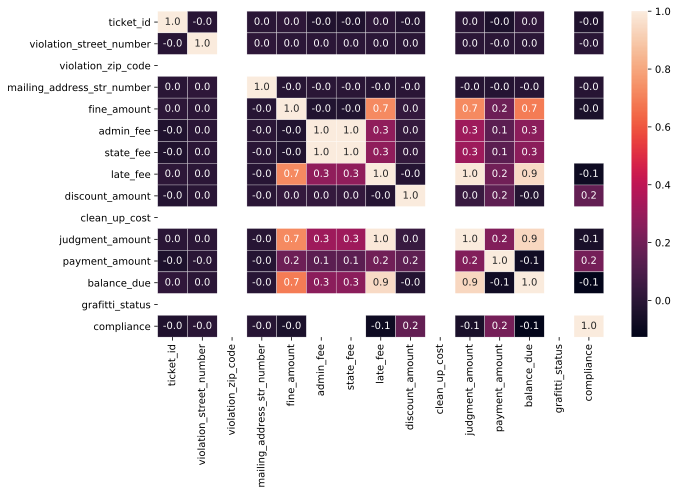

In [40]:
sns.heatmap(df_train.corr(), annot=True, fmt='.1f', linewidths='.3');

In [27]:
%%time
rows_with_missing = [row for row in df_train.index if df_train['compliance'].isnull()[row]]

CPU times: user 2min 15s, sys: 128 ms, total: 2min 15s
Wall time: 2min 19s


In [28]:
columns_drop = ['violation_zip_code', 'non_us_str_code', 'grafitti_status', 'compliance_detail', 
                'payment_amount', 'balance_due', 'payment_date', 'payment_status', 'collection_status']
df_train = df_train.drop(columns_drop, axis=1)
df_train = df_train.drop(rows_with_missing, axis=0)
df_train.shape

(144528, 25)

In [29]:
df_test = pd.read_csv('test_2.csv', index_col='Unnamed: 0')
df_test = df_test.drop(['violation_zip_code', 'non_us_str_code', 'grafitti_status'], axis=1)
df_test.shape

(25305, 24)

In [30]:
passes_num = ['mailing_address_str_number', 'zip_code', 'fine_amount']
passes_cat = ['violator_name', 'mailing_address_str_name', 'state']
passes_date = ['hearing_date']

In [31]:
df_train[passes_num] = df_train[passes_num].fillna(method='ffill')
df_train[passes_cat] = df_train[passes_cat].fillna(method='ffill')
df_train[passes_date] = df_train[passes_date].fillna(method='ffill')

In [49]:
num_variables = ['ticket_id', 'violation_street_number', 'mailing_address_str_number', 'fine_amount',
                 'late_fee', 'discount_amount', 'judgment_amount']
len(num_variables)

7

In [50]:
y = df_train['compliance']
X = df_train[num_variables]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225000 entries, 0 to 224999
Data columns (total 7 columns):
ticket_id                     225000 non-null int64
violation_street_number       225000 non-null float64
mailing_address_str_number    222105 non-null float64
fine_amount                   224999 non-null float64
late_fee                      225000 non-null float64
discount_amount               225000 non-null float64
judgment_amount               225000 non-null float64
dtypes: float64(6), int64(1)
memory usage: 13.7 MB


In [51]:
X.head()

,ticket_id,violation_street_number,mailing_address_str_number,fine_amount,late_fee,discount_amount,judgment_amount
0,22056,2900.0,3.0,250.0,25.0,0.0,305.0
1,27586,4311.0,2959.0,750.0,75.0,0.0,855.0
2,22062,1449.0,23658.0,250.0,0.0,0.0,0.0
3,22084,1441.0,5.0,250.0,0.0,0.0,0.0
4,22093,2449.0,7449.0,250.0,0.0,0.0,0.0


In [ ]:
X['late_fee'].mean()

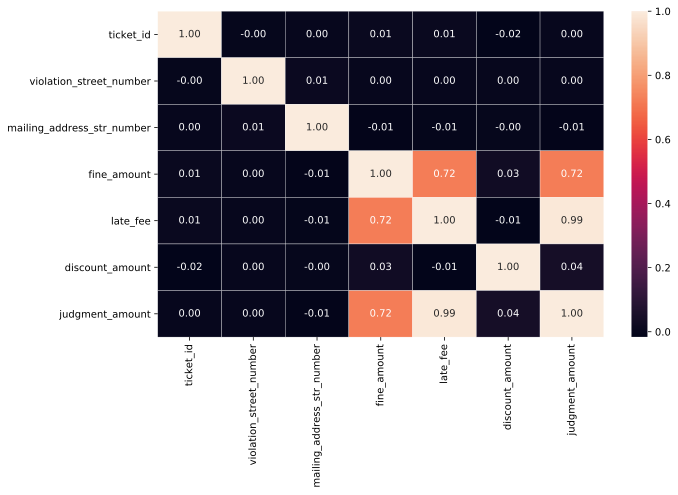

In [53]:
sns.heatmap(X.corr(), annot=True, fmt='.2f', linewidths='.3');

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(X.columns):
    plt.subplot(4, 3, i + 1)
    plt.scatter(X[col], y)
    plt.title(col);

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
arr = []
for i in [1, 10, 25, 50, 100, 250]:
    gbm_model = GradientBoostingClassifier(n_estimators=i, random_state=42)
    gbm_model.fit(X, y)
    score = cross_val_score(gbm_model, X, y, cv=kfold, scoring='roc_auc')
    arr.append(score.mean())

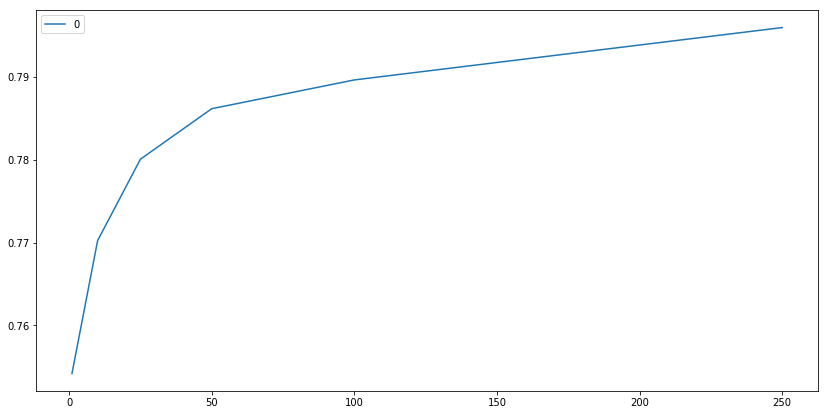

In [36]:
arr_df = pd.DataFrame(arr, [1, 10, 25, 50, 100, 250])
arr_df.plot.line(figsize=(14, 7))